<center><h1>Explore Vaccines Tweets - proxy+Labelled data
   </h1></center>

# Introduction


The Dataset we are using here is collected using Twitter API, **tweepy** and Python package.

The following vaccines are included:  
* Pfizer/BioNTech;   
* Sinopharm;  
* Sinovac;  
* Moderna;  
* Oxford/AstraZeneca;   
* Covaxin;   
* Sputnik V.  



# Data preparation

## Load packages

In [58]:
#! pip install tensorflow==2.6 tensorflow-gpu==2.6 seaborn  lightgbm   pandas plotly  matplotlib nltk numpy gensim wordcloud textblob neattext scikit_learn nbformat transformers tensorflow_hub bert-tensorflow  tf-models-official

In [59]:
#! pip install tensorflow==2.6
import tensorflow as tf
tf.__version__



'2.6.0'

In [60]:
import numpy as np 
import pandas as pd
import matplotlib as mp
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
%matplotlib inline 
from wordcloud import WordCloud, STOPWORDS
##
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
##
import warnings
warnings.simplefilter("ignore")

## Load data

In [61]:
tweets_df = pd.read_csv("tweets_cleaned_labelled.csv", encoding='utf-8')

In [62]:
len(tweets_df)

6000

### For SSl splitting the data to 70-30  , where 30 will be used for final prediction task 





In [63]:
# seperate off train and test
train = tweets_df.iloc[:4200, :]
test = tweets_df.iloc[4200:, :]
#train = tweets_df.sample(frac=0.7,random_state=200)
print(len(train))
#test=tweets_df.drop(train.index)
print(len(test))

# seperate off train and test



4200
1800



### Classification Tasks

In [64]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
#import gensim

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix,recall_score,precision_score,make_scorer
from sklearn.model_selection import StratifiedKFold, train_test_split, learning_curve,cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from statistics import mean, stdev
import lightgbm as lgb
import joblib

# target variable 
y = train["label"].values

no_of_splits=5
# initializing Kfold
skf = StratifiedKFold(n_splits=no_of_splits, shuffle=True, random_state=24)

# count vectorizer transformation
count_vect = CountVectorizer()
count_vect.fit(tweets_df["clean_data"].values.astype('U').tolist())
train_count_vect = count_vect.transform(train["clean_data"].values.astype('U'))
joblib.dump(count_vect, "model/vect/count_vect_labelled.pkl")

# tfidf vectorizer transformation 
tfidf_vect = TfidfVectorizer()
tfidf_vect.fit(tweets_df["clean_data"].values.astype('U').tolist())
train_tfidf_vect = tfidf_vect.transform(train["clean_data"].values.astype('U'))
joblib.dump(tfidf_vect, "model/vect/_tfidf_vect_labelled.pkl")

['model/vect/_tfidf_vect_labelled.pkl']

In [65]:

# light gbm parameters
lgbm_params = {
    "learning_rate": 0.02, 
    "random_state": 24, 
    "metric": "multi_logloss",
    "n_estimators": 2000,
    "objective": "multiclass"
}
# models
models =  {
    "svm": SVC(),
    "logistic_regression": LogisticRegression(),
    "naive_bayes": MultinomialNB(),
    "SGD": SGDClassifier(),
    "random_forest": RandomForestClassifier(class_weight='balanced'),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "LGBM":lgb.LGBMClassifier(**lgbm_params)
    
} 

# current vectors
vectors = {
    "count_vectorizer": train_count_vect,
    "tfidf_vectorizer": train_tfidf_vect
}

In [66]:
def stratified_kfold(clf:str, vect_type:str, y, kfold):
    """
    Perform Kfold Cross-Validation
    :param model: the model used to make predictions
    :param X: the train features being used 
    :param y: the target feature,
    :param kfold: the cross validation strategy
    :return: dictionary with model name key and results as the values
    """
    results = {}
    # store the name of the model in dictionary
    results["modelname_vectorType"] = clf + "_" + vect_type
    
    # call the model and training data
    model = models[clf]
    X = vectors[vect_type]

    f1score_list= []
    lst_accu_stratified = []
    # perfrom kfold cv
    for fold, (train_idx, valid_idx) in enumerate(kfold.split(X, y)):
        #print(f"\nCurrently Training: {results['modelname_vectorType']}... Fold: {fold+1}")
        X_train, X_valid = X[train_idx], X[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        
        # train on seen data, predict on unseen
        model.fit(X_train, y_train)
        y_preds = model.predict(X_valid)
        f1score = f1_score(y_valid, y_preds,average='weighted')
        results["fold_{}".format(fold+1)] = f1score
        lst_accu_stratified.append(model.score(X_valid, y_valid))
        f1score_list.append(f1score)
    results["accuracy"] = "%.3f%%" % (mean(lst_accu_stratified) * 100)
    joblib.dump(model, "model/ml/"+clf + "_" + vect_type+".pkl")
    return results

In [67]:
def stratified_kfold_lbgm(clf:str, vect_type:str, y, kfold):
    """
    Perform Kfold Cross-Validation
    :param model: the model used to make predictions
    :param X: the train features being used 
    :param y: the target feature,
    :param kfold: the cross validation strategy
    :return: dictionary with model name key and results as the values
    """
    results = {}
    # store the name of the model in dictionary
    results["modelname_vectorType"] = clf + "_" + vect_type
    
    # call the model and training data
    model = models[clf]
    X = vectors[vect_type]
    
    f1score_list= []
    lst_accu_stratified = []
    # perfrom kfold cv
    for fold, (train_idx, valid_idx) in enumerate(kfold.split(X, y)):
        print(f"\nCurrently Training: {results['modelname_vectorType']}... Fold: {fold+1}")
        X_train, X_valid= X[train_idx].astype(np.float64), X[valid_idx].astype(np.float64)
        y_train, y_valid= y[train_idx].astype(np.float64), y[valid_idx].astype(np.float64)
        # train on seen data, predict on unseen
        model.fit(X_train,
             y_train,
             eval_set=[(X_valid, y_valid)],
             verbose=100,
             early_stopping_rounds=100)
        
        y_preds = model.predict(X_valid)
        f1score = f1_score(y_valid, y_preds,average='weighted')
        results["fold_{}".format(fold+1)] = f1score
        lst_accu_stratified.append(model.score(X_valid, y_valid))
        f1score_list.append(f1score)


    results["accuracy"] = "%.3f%%" % (mean(lst_accu_stratified) * 100)
    joblib.dump(model, "model/ml/"+clf + "_" + vect_type+".pkl")
    return results

In [ ]:
# store all models
all_models = []
for clf in models:
    for vect in vectors:
        if clf == "LGBM":
            all_models.append(stratified_kfold_lbgm(clf, vect, y, skf))
        else:
            all_models.append(stratified_kfold(clf, vect, y, skf))            
        print(f"Current Model: {clf}_{vect}...\n")

Current Model: svm_count_vectorizer...

Current Model: svm_tfidf_vectorizer...

Current Model: logistic_regression_count_vectorizer...

Current Model: logistic_regression_tfidf_vectorizer...

Current Model: naive_bayes_count_vectorizer...

Current Model: naive_bayes_tfidf_vectorizer...

Current Model: SGD_count_vectorizer...

Current Model: SGD_tfidf_vectorizer...

Current Model: random_forest_count_vectorizer...

Current Model: random_forest_tfidf_vectorizer...

Current Model: DecisionTreeClassifier_count_vectorizer...

Current Model: DecisionTreeClassifier_tfidf_vectorizer...

Current Model: KNeighborsClassifier_count_vectorizer...

Current Model: KNeighborsClassifier_tfidf_vectorizer...


Currently Training: LGBM_count_vectorizer... Fold: 1
[100]	valid_0's multi_logloss: 0.693978
[200]	valid_0's multi_logloss: 0.689513

Currently Training: LGBM_count_vectorizer... Fold: 2
[100]	valid_0's multi_logloss: 0.685802
[200]	valid_0's multi_logloss: 0.68367

Currently Training: LGBM_count_v

In [ ]:
models_df = pd.DataFrame(all_models)
models_df

In [ ]:
import tensorflow
tensorflow.__version__

### Word2Vec Embeddings

In [ ]:
train["label"].unique()

In [ ]:
labels = tf.keras.utils.to_categorical(train["label"], dtype="float32")

In [ ]:
labels

In [ ]:
import gensim.downloader as api
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Bidirectional,SpatialDropout1D,GRU,Conv1D,MaxPooling1D
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers, Sequential


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
max_words = 5000
max_len = 200

n_epochs = 8
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train["clean_data"].values.astype('U'))
sequences = tokenizer.texts_to_sequences(train["clean_data"].values.astype('U'))
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

In [ ]:
#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(tweets,labels, random_state=0)
print (len(X_train),len(X_test),len(y_train),len(y_test))

In [ ]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''
    
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    


In [ ]:
## LSTM 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import datasets

from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import History

from tensorflow.keras import losses
vocab_size = 5000
embedding_size = 32
epochs=20
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8
max_len=50



sgd1 = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
model1 = Sequential()
model1.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model1.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model1.add(MaxPooling1D(pool_size=2))
model1.add(LSTM(15,dropout=0.5))
model1.add(Dense(3,activation='softmax'))

# initializing early stopping 
early_stopping = EarlyStopping(monitor='loss', patience=3)

print(model1.summary())
# Compile model
model1.compile(loss='categorical_crossentropy', optimizer=sgd1, 
               metrics=['accuracy'])
checkpoint = ModelCheckpoint('model/dl/lstm_best_model.h5', monitor='val_loss', save_best_only=True)
# Train model
batch_size = 64
history1 = model1.fit(X_train, y_train,
                      validation_data=(X_test, y_test),callbacks=[early_stopping,checkpoint],
                      batch_size=batch_size, epochs=epochs, verbose=1)
print('LSTM Best model saved')

In [ ]:
plot_training_hist(history1)

In [ ]:
## BILSTM

sgd2 = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
# Build model
model2= Sequential()
model2.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model2.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Bidirectional(LSTM(32)))
model2.add(Dropout(0.4))
model2.add(Dense(3, activation='softmax'))

# initializing early stopping 
early_stopping = EarlyStopping(monitor='loss', patience=3)

print(model2.summary())

# Compile model
model2.compile(loss='categorical_crossentropy', optimizer=sgd2, 
               metrics=['accuracy'])

# Train model
checkpoint = ModelCheckpoint('model/dl/bi_lstm_best_model.h5', monitor='val_loss', save_best_only=True)
batch_size = 64
history2 = model2.fit(X_train, y_train,
                      validation_data=(X_test, y_test),callbacks=[early_stopping,checkpoint],
                      batch_size=batch_size, epochs=epochs, verbose=1)

print('BILSTM Best model saved')

In [ ]:
plot_training_hist(history2)

In [ ]:
## GRU

sgd3 = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
# Build model
model3= Sequential()
model3.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model3.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model3.add(MaxPooling1D(pool_size=2))
model3.add(GRU(units=64,  dropout=0.2, recurrent_dropout=0.2))
model3.add(Dropout(0.4))
model3.add(Dense(3, activation='softmax'))

# initializing early stopping 
early_stopping = EarlyStopping(monitor='loss', patience=3)

print(model3.summary())

# Compile model
model3.compile(loss='categorical_crossentropy', optimizer=sgd3, 
               metrics=['accuracy'])

# Train model
checkpoint = ModelCheckpoint('model/dl/gru_best_model.h5', monitor='val_loss', save_best_only=True)
batch_size = 64
history3 = model3.fit(X_train, y_train,
                      validation_data=(X_test, y_test),callbacks=[early_stopping,checkpoint],
                      batch_size=batch_size, epochs=epochs, verbose=1)

print('GRU Best model saved')

In [ ]:
plot_training_hist(history3)

<b><u>BILSTM Model seems to perform well compared to othe  deep learning models </b></u>

### BERT

In [34]:
# install transformers


In [35]:
#import tensorflow as tf
#from tensorflow.keras.layers import Dense, Input
#from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.models import Model
#from tensorflow.keras.callbacks import ModelCheckpoint


import transformers
from tqdm.notebook import tqdm
from tokenizers import BertWordPieceTokenizer

In [36]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    
except:
    strategy = tf.distribute.get_strategy()
    
print('Number of replicas in sync: ', strategy.num_replicas_in_sync)

Number of replicas in sync:  1


In [37]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')

def bert_encode(data, maximum_length) :
    input_ids = []
    attention_masks = []

    for text in data:
        encoded = tokenizer.encode_plus(
            text, 
            add_special_tokens=True,
            max_length=maximum_length,
            pad_to_max_length=True,

            return_attention_mask=True,
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    return np.array(input_ids),np.array(attention_masks)


In [38]:
texts = train["clean_data"].values.astype('U')
target = labels


train_input_ids, train_attention_masks = bert_encode(texts,60)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [39]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

def create_model(bert_model):
    
    input_ids = tf.keras.Input(shape=(60,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(60,),dtype='int32')

    output = bert_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(32,activation='relu')(output)
    output = tf.keras.layers.Dropout(0.2)(output)
    output = tf.keras.layers.Dense(3,activation='softmax')(output)
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(Adam(lr=3e-5, decay = 1e-6), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [40]:
from transformers import TFBertModel
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [41]:
bb_model = create_model(bert_model)
bb_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 32)           24608       tf_bert_model[0][1]          

In [42]:
early_stopping=EarlyStopping(monitor='val_loss', patience=3)
checkpoint = ModelCheckpoint('base_bert_model.h5', monitor='val_loss', save_best_only=True)
history4 = bb_model.fit(
    [train_input_ids, train_attention_masks],
    target,
    validation_split=0.3, 
    epochs=6,
    batch_size=10,callbacks=[early_stopping]
)

Epoch 1/6
294/294 [==============================] - 28s 70ms/step - loss: 0.8051 - accuracy: 0.6405 - val_loss: 0.9766 - val_accuracy: 0.5683
Epoch 2/6
294/294 [==============================] - 19s 65ms/step - loss: 0.6262 - accuracy: 0.7354 - val_loss: 0.8320 - val_accuracy: 0.6421
Epoch 3/6
294/294 [==============================] - 19s 66ms/step - loss: 0.4936 - accuracy: 0.8092 - val_loss: 0.8400 - val_accuracy: 0.6762
Epoch 4/6
294/294 [==============================] - 19s 66ms/step - loss: 0.3495 - accuracy: 0.8656 - val_loss: 1.1069 - val_accuracy: 0.6841
Epoch 5/6
294/294 [==============================] - 19s 66ms/step - loss: 0.2438 - accuracy: 0.9150 - val_loss: 1.1850 - val_accuracy: 0.6603


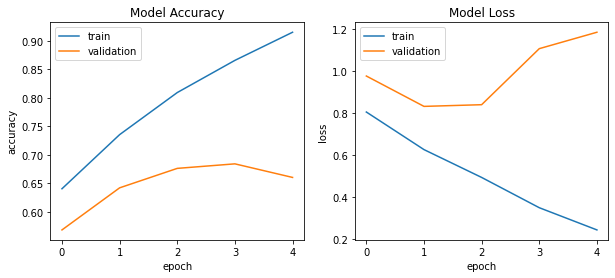

In [43]:
plot_training_hist(history4)

In [44]:
#model.save('bert_base_best_model',save_format='h5')
#print('Bert Best model saved')


# https://github.com/huggingface/transformers/issues/4444

##model.save_weights('bert_base_model_weights')

###  COVID Twitter bert 

In [45]:
#! pip install pydot graphviz
#tf.keras.utils.plot_model(model)

In [46]:
#! pip install tensorflow_hub bert-tensorflow

#! pip install tf-models-official

In [47]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub

import tensorflow_hub as hub

# Load the required submodules
from  official.nlp.bert import tokenization


In [48]:
def ct_bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [49]:
%%time
 
bert_layer = hub.KerasLayer("https://tfhub.dev/digitalepidemiologylab/covid-twitter-bert/2", trainable=True)
#pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])


INFO:absl:Using /tmp/tfhub_modules to cache modules.


CPU times: user 6.02 s, sys: 896 ms, total: 6.91 s
Wall time: 6.83 s


In [50]:
def build_ct_model1(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    input_type_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_type_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])
    clf_output = sequence_output[:, 0, :]
    output = tf.keras.layers.Dropout(0.5)((clf_output))
    output = Dense(3, activation='sigmoid')(output)
    
    model = Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)
    # Compile model
    model.compile(Adam(lr=2e-5,  decay = 1e-6), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [51]:
def build_ct_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    input_type_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_type_ids")

    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])
    num_labels = 3
    initializer = tf.keras.initializers.TruncatedNormal(stddev=0.2)
    output = tf.keras.layers.Dropout(rate=0.2)(pooled_output)
    #output = tf.keras.layers.Dense(num_labels, kernel_initializer=initializer, name='output')(output)
    #output = tf.keras.layers.Dense(32,activation='relu')(output)
    #output = tf.keras.layers.Dropout(0.2)(output)
    #output = tf.keras.layers.Dense(3,activation='softmax')(output)

    classifier_model = tf.keras.Model(
      inputs={
              'input_word_ids': input_word_ids,
              'input_mask': input_mask,
              'input_type_ids': input_type_ids},
      outputs=output)
    classifier_model.compile(Adam(lr=2e-5, decay = 1e-6), loss='categorical_crossentropy', metrics=['accuracy'])
    return classifier_model

In [52]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [53]:
texts = train["clean_data"].values.astype('U')
target = labels

train_input = ct_bert_encode(texts, tokenizer, max_len=100)
train_labels = target



In [54]:

ct_model = build_ct_model1(bert_layer, max_len=100)
ct_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [55]:
#early_stopping=EarlyStopping(monitor='loss', patience=3)
#history5 = model.fit(
#    [train_input_ids, train_attention_masks],
#    target,
#    validation_split=0.2, 
#    epochs=6,
#    batch_size=10,callbacks=[early_stopping]
#)

In [56]:
checkpoint = ModelCheckpoint('model/bert/ct_bert_model.h5', monitor='val_loss', save_best_only=True)

train_history = ct_model.fit(
    train_input, train_labels,
    validation_split=0.30,
    epochs=5,
    callbacks=[checkpoint],
    batch_size=10
)

Epoch 1/5
294/294 [==============================] - 116s 302ms/step - loss: 1.2211 - accuracy: 0.6139 - val_loss: 0.8690 - val_accuracy: 0.6794
Epoch 2/5
294/294 [==============================] - 87s 296ms/step - loss: 0.8182 - accuracy: 0.7092 - val_loss: 0.8451 - val_accuracy: 0.7008
Epoch 3/5
294/294 [==============================] - 87s 297ms/step - loss: 0.5807 - accuracy: 0.7901 - val_loss: 1.0382 - val_accuracy: 0.7008
Epoch 4/5
294/294 [==============================] - 87s 296ms/step - loss: 0.3773 - accuracy: 0.8609 - val_loss: 1.1290 - val_accuracy: 0.6817
Epoch 5/5
294/294 [==============================] - 87s 296ms/step - loss: 0.2422 - accuracy: 0.9099 - val_loss: 1.4076 - val_accuracy: 0.7071


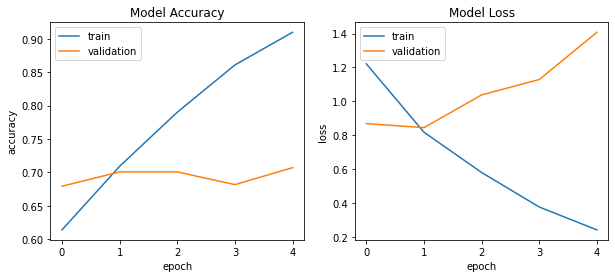

In [57]:
plot_training_hist(train_history)